## Transfer Learning 

### Processed in _Google Colab_!

If the training data is small, like the one we used for cats and dogs classification task (2000 training images), then a netowrk may find it hard learn to all the detailed common features, even with data augmentation. Transfer learning is a process of using an existing model, that is trained with far more data and use the features that model learn to use in our classification tasks. Here we will use [Inception Model](https://ai.google/research/pubs/pub43022). 

For a Tensorflow tutorial on transfer learning, you can check [this](https://www.tensorflow.org/tutorials/images/transfer_learning) page. 

Keras also has a much detailed tutorial of the same on the [Applications page](https://keras.io/applications/). 

Francis Chollet's github has [list of pretrinaed model weights](https://github.com/fchollet/deep-learning-models/releases). Check there to download the ones you need. Sadly it didn't work, so I downloaded from [Kaggle](https://www.kaggle.com/madmaxliu/inceptionv3).  

More detailed description about different famous deep networks are given [here](https://cv-tricks.com/cnn/understand-resnet-alexnet-vgg-inception/).  

## !!!! This notebook is prepared using VGG Weights !!!! 

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, time

In [0]:
keras = tf.keras

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')   

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls "/content/gdrive/My Drive"

'Colab Notebooks'  'Getting started.pdf'


In [0]:
from keras.applications.vgg16 import VGG16

VGG_pretrained_weight = '/content/gdrive/My Drive/Colab Notebooks/pretrained_weight/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = VGG16(input_shape=(160, 160, 3), 
                               include_top=False, 
                               weights=VGG_pretrained_weight)


for lr in pre_trained_model.layers:
    lr.trainable = False
    
    
# for layr in pre_trained_model.layers:
    # print("layer names: ", layr.name)

In [0]:
last_layer = pre_trained_model.get_layer('block4_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 10, 10, 512)


Let's see what actually happened here. 

* First import VGG16 model. 
* Save the downloaded model.h5 file in a folder. 
* Create a pre-trained-model using VGG16. But here we make sure about the following stuffs-- 
    * Define the shape of the input image. 
    * Set include_top = Do not include 3 fully connected layers at the top.  
    * For the weights, rather than training them we load it from the pre-trained model. 
* Once the pretrained model is instantiated, we iterate over the layers and lock them from training. So they will be treated as non-trainable parameters. 
* Now instead of using the whole network, we will set some layer depth by and obtain the output from that layer. Here I have used 'block4_pool' which has a shape of (None, 10, 10, 512), which means area of the image now is $10\times 10$. Fairly good amount of region to get some info out of it. 
* Next we define our model and, train the network. Below I have added some a dense layer, a droput layer and finally the output layer. 
* Use Adam Optimizer and set the learning rate to a rather small value. 

In [0]:
from keras.optimizers import Adam
from keras import layers, Model

# Flatten the output layer to 1 dimension
# x = layers.MaxPool2D(2, 2)(last_output)
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [0]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0   

### Data Preprocessing 

Follow the same procedures as before to load train and validation data from folders using ImageGenerator. 

In [0]:
cat_train_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/train/cats')
dog_train_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/train/dogs')

cat_test_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/test/cats')
dog_test_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/test/dogs')


cat_train_images = os.listdir(cat_train_dir)
dog_train_images = os.listdir(dog_train_dir)


print ("number of cat training images: ", len(os.listdir(cat_train_dir)))
print ("number of dog training images: ", len(os.listdir(dog_train_dir)))

print ("number of cat test images: ", len(os.listdir(cat_test_dir)))
print ("number of dog test images: ", len(os.listdir(dog_test_dir)))




from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.,  
                                  horizontal_flip=True,
                                  zoom_range=0.0, 
                                  height_shift_range=0.2,
                                  width_shift_range=0.1)


test_datagen = ImageDataGenerator(rescale=1/255.,)


train_datagenerator = train_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/train', 
                                                       batch_size=28, 
                                                       class_mode='binary', 
                                                       target_size=(160, 160))

test_datagenerator = test_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/test', 
                                                     batch_size=15, 
                                                     class_mode='binary', 
                                                     target_size=(160, 160))

number of cat training images:  1400
number of dog training images:  1401
number of cat test images:  301
number of dog test images:  300
Found 2801 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


In [0]:
history = model.fit_generator(train_datagenerator, 
                              steps_per_epoch=100, 
                              epochs=20, 
                              validation_data=test_datagenerator, 
                              validation_steps=40, 
                              verbose=2)



Epoch 1/20
 - 1280s - loss: 1.1156 - acc: 0.7069 - val_loss: 0.3317 - val_acc: 0.8617
Epoch 2/20
 - 34s - loss: 0.4076 - acc: 0.8207 - val_loss: 0.3732 - val_acc: 0.8276
Epoch 3/20
 - 35s - loss: 0.3538 - acc: 0.8482 - val_loss: 0.2643 - val_acc: 0.8857
Epoch 4/20
 - 34s - loss: 0.3280 - acc: 0.8543 - val_loss: 0.2705 - val_acc: 0.8891
Epoch 5/20
 - 34s - loss: 0.3025 - acc: 0.8693 - val_loss: 0.2229 - val_acc: 0.8993
Epoch 6/20
 - 34s - loss: 0.2831 - acc: 0.8764 - val_loss: 0.2282 - val_acc: 0.9113
Epoch 7/20
 - 34s - loss: 0.2986 - acc: 0.8725 - val_loss: 0.2042 - val_acc: 0.9232
Epoch 8/20
 - 34s - loss: 0.2428 - acc: 0.8986 - val_loss: 0.1972 - val_acc: 0.9147
Epoch 9/20
 - 33s - loss: 0.2255 - acc: 0.9061 - val_loss: 0.1844 - val_acc: 0.9147
Epoch 10/20
 - 33s - loss: 0.2176 - acc: 0.9096 - val_loss: 0.2268 - val_acc: 0.8908
Epoch 11/20
 - 33s - loss: 0.2144 - acc: 0.9118 - val_loss: 0.2470 - val_acc: 0.8942
Epoch 12/20
 - 34s - loss: 0.2266 - acc: 0.9000 - val_loss: 0.2228 - v

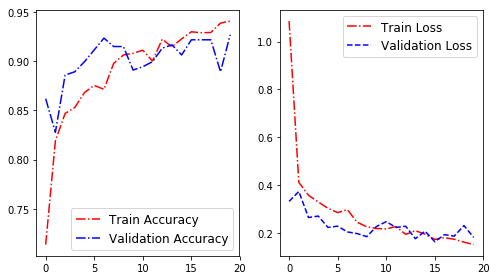

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, acc, linestyle='-.', color='red', label='Train Accuracy')
# plt.plot(epochs, val_acc, linestyle='--', color='blue', label='Validation Accuracy')
# plt.legend(fontsize=12)
# plt.subplot(1, 2, 2)
# plt.plot(epochs, loss, linestyle='-.', color='red', label='Train Loss')
# plt.plot(epochs, val_loss, linestyle='--', color='blue', label='Validation Loss')
# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
axes[0].plot(epochs, acc, linestyle='-.', color='red', label='Train Accuracy')
axes[0].plot(epochs, val_acc, linestyle='-.', color='blue', label='Validation Accuracy')
axes[0].legend(fontsize=12)
axes[1].plot(epochs, loss, linestyle='-.', color='red', label='Train Loss')
axes[1].plot(epochs, val_loss, linestyle='--', color='blue', label='Validation Loss')
axes[1].legend(fontsize=12)
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/VGG16_loss_acc.png', dpi=200)
fig.tight_layout()

Prediction on Unknown Images 

result vector:  [[0.        ]
 [0.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.        ]
 [0.        ]
 [0.66472596]
 [1.        ]]
arg_result type:  <class 'numpy.ndarray'>
arg_result : [0 0 0 0 0 0 0 0 0 0 0 0]


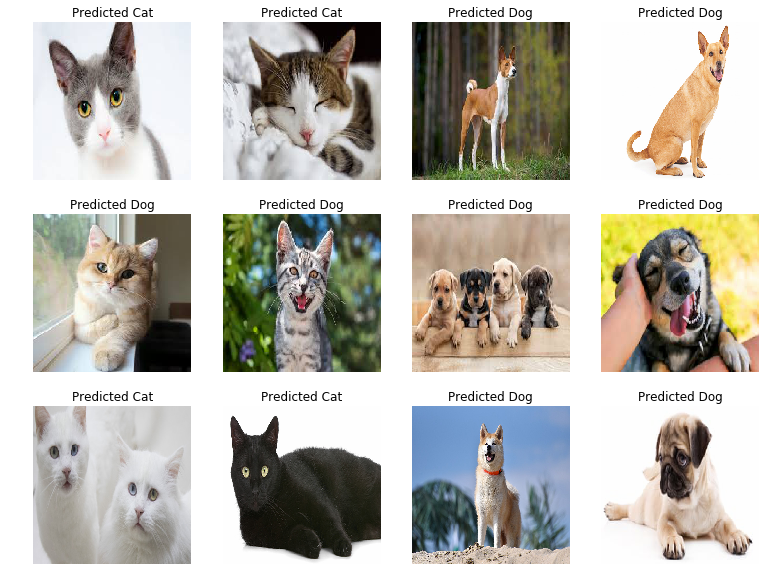

In [0]:
from keras.preprocessing import image 

rand_ims_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/fromnet')

random_images = os.listdir(rand_ims_dir)

IMG_SIZE = 160

batch_holder = np.zeros((12, IMG_SIZE, IMG_SIZE, 3)) # folder contains 6 images 
for i,img in enumerate(random_images):
    img= image.load_img(os.path.join(rand_ims_dir,img), target_size=(IMG_SIZE,IMG_SIZE))
    batch_holder[i, :] = img

result = model.predict(batch_holder)
arg_result = np.argmax(result, axis=1)
# 
print("result vector: ", result)
print ("arg_result type: ", type(arg_result))
print ("arg_result :", arg_result)
# 
fig = plt.figure(figsize=(13, 10))
 
for i,img in enumerate(batch_holder):
    fig.add_subplot(3,4, i+1)
    plt.axis("off")
    if result[i][0]>0:
        plt.title("Predicted Dog")
    else:
        plt.title("Predicted Cat")
    plt.axis("off")    
    plt.imshow(img/256.)

# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Prediction_with_Vgg_CatsDogs.png', dpi=300)
# 